problem: Using posts on reddit to predict whether that post is fake or not 

input: text data

output: probability that represent the model certainty of whether that post is fake or not

the Challenges: how to convert that text data to numerical values so the algorithms can understand it, what method to use between count vectorizer or tf-idf vectorizer  which algorithms will perform better on text data with that much of dimensonality

impact: with that model you can predict with a 83% (which is the highest score that I got on the board) that people are telling the truth or not by just analysing the post 

Ideal solution: I think if we use models with high capacity neural network for example it will perform better a text data is data with complex structure and NN can involve that complexity

### Supervisedlearning steps
1- collect and preprocess data

2- determine a label 

3- split data into train and validation

4- extract features from text

5- predict values using test data


In [1]:
# import libraries
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [2]:
#reading data
df = pd.read_csv('xy_train.csv')

### Data exploration

In [3]:
# show first 5 rows
df.head()

,id,text,label
0,265723,A group of friends began to volunteer at a hom...,0
1,284269,British Prime Minister @Theresa_May on Nerve A...,0
2,207715,"In 1961, Goodyear released a kit that allows P...",0
3,551106,"Happy Birthday, Bob Barker! The Price Is Right...",0
4,8584,"Obama to Nation: 聙""Innocent Cops and Unarmed Y...",0


In [4]:
# check if the data has null values or not
df.isnull().sum()

id       0
text     0
label    0
dtype: int64

In [5]:
# show a brief review a bout the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      60000 non-null  int64 
 1   text    60000 non-null  object
 2   label   60000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


In [6]:
# frequency of each class
df['label'].value_counts()

0    32172
1    27596
2      232
Name: label, dtype: int64

## Preprocessing

###bag-of-words

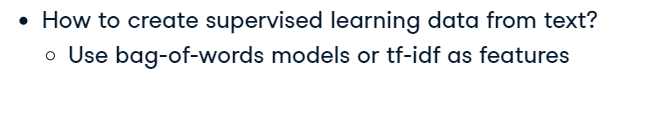

####Text Preprocessing

In [7]:
import nltk
nltk.download('stopwords')
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))


def clean_text(text, for_embedding=False):
    """ steps:
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
import re
nltk.download('punkt')

df["post_clean"] = df.loc[df["text"].str.len() > 20, "text"]
df["post_clean"] = df["post_clean"].map(
    lambda x: clean_text(x, for_embedding=False) if isinstance(x, str) else x
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
df.head()

,id,text,label,post_clean
0,265723,A group of friends began to volunteer at a hom...,0,group friend began volunt homeless shelter nei...
1,284269,British Prime Minister @Theresa_May on Nerve A...,0,british prime minist theresa may nerv attack f...
2,207715,"In 1961, Goodyear released a kit that allows P...",0,goodyear releas kit allow ps brought heel http...
3,551106,"Happy Birthday, Bob Barker! The Price Is Right...",0,happi birthday bob barker price right host lik...
4,8584,"Obama to Nation: 聙""Innocent Cops and Unarmed Y...",0,obama nation innoc cop unarm young black men d...


In [10]:
import nltk
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('averaged_perceptron_tagger')

import nltk 

# Tokenize each sentence into words: token_sentences
token_sentences = [nltk.word_tokenize(sent.lower()) for sent in  df['text']]

# Tag each tokenized sentence into parts of speech: pos_sentences
pos_sentences = [nltk.pos_tag(sent) for sent in token_sentences] 

# Create the named entity chunks: chunked_sentences
chunked_sentences = nltk.ne_chunk_sents(pos_sentences, binary=True)
chunked_sentences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


<generator object ParserI.parse_sents.<locals>.<genexpr> at 0x7f4a4424b850>

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


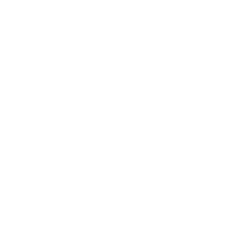

In [12]:
nltk.download('words')
# Create the defaultdict: ner_categories
from collections import defaultdict
ner_categories = defaultdict(int)

# Create the nested for loop
for sent in chunked_sentences:
    for chunk in sent:
        if hasattr(chunk, 'label'):
            ner_categories[chunk.label()] += 1
            
# Create a list from the dictionary keys for the chart labels: labels
labels = list(ner_categories.keys())

# Create a list of the values: values
values = [ner_categories.get(v) for v in labels]

# Create the pie chart
import matplotlib.pyplot as plt
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)

# Display the chart
plt.show()


In [14]:
from gensim.corpora.dictionary import Dictionary
from nltk.tokenize import word_tokenize

tokenized_docs = [word_tokenize(doc.lower()) for doc in df['text']]
dictionary = Dictionary(tokenized_docs)   

from gensim.corpora.dictionary import Dictionary

# Create a Dictionary from the articles: dictionary
#dictionary = Dictionary()

# Create a MmCorpus: corpus
corpus = [dictionary.doc2bow(post) for post in tokenized_docs]

# Print the first 10 word ids with their frequency counts from the fifth document
print(corpus[4][:10])

[(0, 4), (1, 1), (2, 112), (3, 1), (4, 5), (6, 3), (7, 6), (8, 6), (10, 17), (11, 5)]


In [15]:
from numpy.ma.core import count
from sklearn.model_selection import train_test_split

y = df.label
df.drop(['label', 'id',], axis = 1, inplace = True)
# splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size= .2, random_state=42)

#### Trial 1

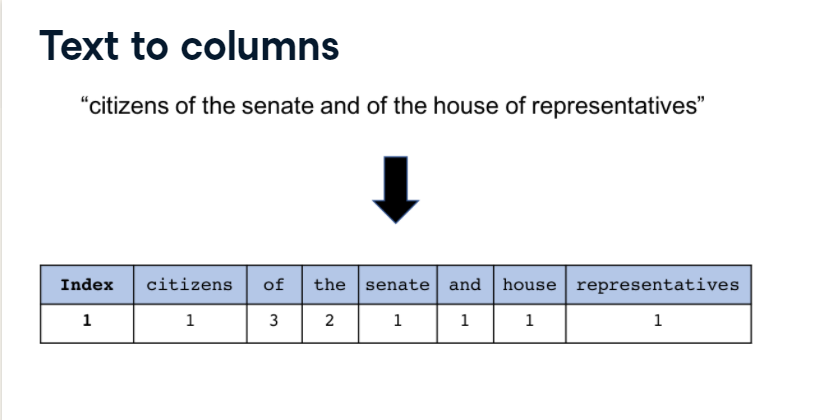

[Datacamp fake-news-classifier](https://campus.datacamp.com/courses/introduction-to-natural-language-processing-in-python/building-a-fake-news-classifier?ex=1)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(stop_words = 'english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

In [17]:
# Import the necessary modules
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred)
print(cm)

0.7804166666666666
[[4724 1648    2]
 [ 940 4641    0]
 [  38    7    0]]


Training the model with the original column without cleaning with regular expressions

In [18]:
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(df['post_clean'], y, test_size= .2, random_state=42)

count_train_clean = count_vectorizer.fit_transform(X_train_clean)
count_test_clean = count_vectorizer.transform(X_test_clean)

# Fit the classifier to the training data
nb_classifier.fit(count_train_clean, y_train_clean)

# Create the predicted tags: pred
pred_clean = nb_classifier.predict(count_test_clean)

# Calculate the accuracy score: score
score_clean = metrics.accuracy_score(y_test_clean, pred_clean)
print(score_clean)

# Calculate the confusion matrix: cm
cm_clean = metrics.confusion_matrix(y_test_clean, pred_clean)
print(cm_clean)

0.7605833333333333
[[4568 1804    2]
 [1022 4559    0]
 [  33   12    0]]


#### Trial 2

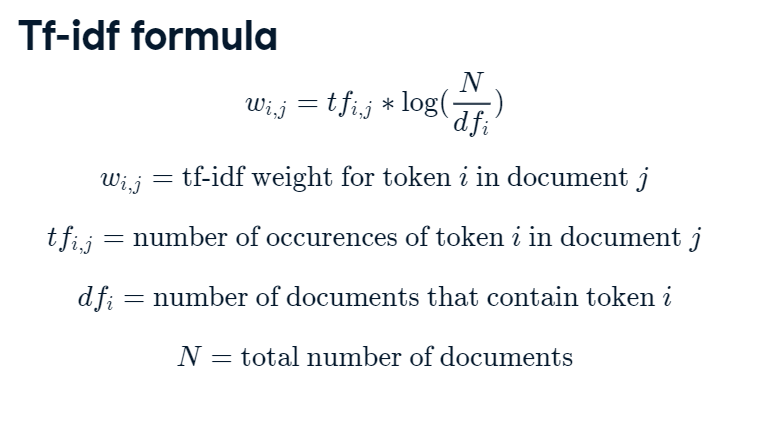

word-level vectorizer

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer(stop_words = 'english', analyzer="word")
train_idf = tf_idf.fit_transform(X_train)
test_idf = tf_idf.transform(X_test)

In [20]:
# Import the necessary modules
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
nb_classifier = MultinomialNB()
# Fit the classifier to the training data
nb_classifier.fit(train_idf, y_train)

# Create the predicted tags: pred
pred_idf = nb_classifier.predict(test_idf)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred_idf)
print(score)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred_idf)
print(cm)

0.7805833333333333
[[5129 1245    0]
 [1343 4238    0]
 [  38    7    0]]


after building a "fake news" classifier, 

I willl investigate what it has learned

 by mapping the important vector weights back to actual words 

In [21]:
import warnings
warnings.filterwarnings('ignore')

class_labels = nb_classifier.classes_
feature_names = tf_idf.get_feature_names()

# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(nb_classifier.coef_[0], feature_names))

# Print the first class label and the top 20 feat_with_weights entries
print(class_labels[0], feat_with_weights[:20])

# Print the second class label and the bottom 20 feat_with_weights entries
print(class_labels[1], feat_with_weights[-20:])


0 [(-11.861944233251945, '000c'), (-11.861944233251945, '000ft'), (-11.861944233251945, '000km'), (-11.861944233251945, '000m'), (-11.861944233251945, '000n'), (-11.861944233251945, '000拢'), (-11.861944233251945, '000鈥'), (-11.861944233251945, '007'), (-11.861944233251945, '00m'), (-11.861944233251945, '014'), (-11.861944233251945, '016'), (-11.861944233251945, '020th'), (-11.861944233251945, '022'), (-11.861944233251945, '023'), (-11.861944233251945, '0230527'), (-11.861944233251945, '030'), (-11.861944233251945, '03鈥'), (-11.861944233251945, '067594d101f51f7bc1800f0fd15ef65067fb788e'), (-11.861944233251945, '075'), (-11.861944233251945, '086')]
1 [(-7.11717150214767, 'know'), (-7.107473098532296, 'day'), (-7.065967438847404, '2017'), (-7.054027580509797, 'world'), (-7.0239241348342265, 'president'), (-7.023246068781176, 'german'), (-7.006062871091169, 'time'), (-6.984914013572865, 'life'), (-6.911428732295224, 'american'), (-6.903713730345547, '2018'), (-6.820286685369702, 'man'), (-

#### Trial 3

####TfidfVectorizer for text classification

character-level vectorizer 

In [22]:
tf_idf_char = TfidfVectorizer(stop_words = 'english', analyzer="char")
train_idf_char = tf_idf.fit_transform(X_train)
test_idf_char = tf_idf.transform(X_test)

In [23]:
# Fit the classifier to the training data
nb_classifier.fit(train_idf_char, y_train)

# Create the predicted tags: pred
pred_idf_char = nb_classifier.predict(test_idf_char)

# Calculate the accuracy score: score
score_char = metrics.accuracy_score(y_test, pred_idf_char)
print(score_char)

# Calculate the confusion matrix: cm
cm_char = metrics.confusion_matrix(y_test, pred_idf_char)
print(cm_char)

0.7805833333333333
[[5129 1245    0]
 [1343 4238    0]
 [  38    7    0]]


#### Trial 4

In [24]:
from xgboost.sklearn import XGBClassifier
xgboost = XGBClassifier()
xgboost.fit(train_idf, y_train)

# Create the predicted tags: pred
pred_boost = xgboost.predict(test_idf)

# Calculate the accuracy score: score
score_boost = metrics.accuracy_score(y_test, pred_boost)
print(score_boost)

# Calculate the confusion matrix: cm
cm_boost = metrics.confusion_matrix(y_test, pred_boost)
print(cm)

0.6846666666666666
[[5129 1245    0]
 [1343 4238    0]
 [  38    7    0]]


#### Trial 5

In [25]:

xgboost.fit(count_train, y_train)

# Create the predicted tags: pred
pred_boost_count = xgboost.predict(count_test)

# Calculate the accuracy score: score
score_boost_count = metrics.accuracy_score(y_test, pred_boost_count)
print(score_boost)

# Calculate the confusion matrix: cm
cm_boost_count = metrics.confusion_matrix(y_test, pred_boost_count)
print(cm)

0.6846666666666666
[[5129 1245    0]
 [1343 4238    0]
 [  38    7    0]]


#### hyperparamter search method

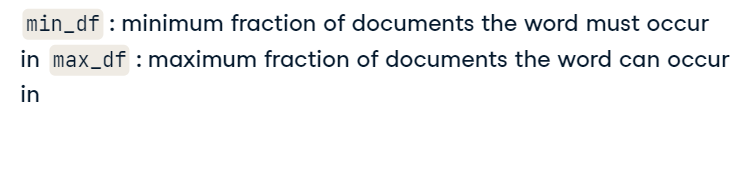

In [ ]:

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import numpy as np
# feature creation and modelling in a single function
pipe = Pipeline([("tfidf", TfidfVectorizer()), ('my_classifier', 
           XGBClassifier())])

# define parameter space to test # runtime 19min
xgb_param = {'my_classifier__learning_rate': [.001, .01, 0.1],
    'my_classifier__n_estimators': [40, 100, 500],  
     # my_classifier__n_estimators points to my_classifier->n_estimators 
    'my_classifier__max_depth':[10, 20, 30]       
}

Random_search = RandomizedSearchCV(
    pipe, xgb_param, cv=2, verbose=1, n_jobs=2, 
    # number of random trials
    n_iter=10,
    scoring='roc_auc')

Random_search.fit(df['text'], y)

print('best score {}'.format(Random_search.best_score_))
print('best score {}'.format(Random_search.best_params_))

Fitting 2 folds for each of 10 candidates, totalling 20 fits


### Inspecting your model

#### Trial 6

In [36]:
import numpy as np
alphas = np.arange(0, 1, .1)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha= alpha)
    # Fit to the training data
    nb_classifier.fit(train_idf, y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(test_idf)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0.0
Score:  0.7390833333333333

Alpha:  0.1
Score:  0.7716666666666666

Alpha:  0.2
Score:  0.776

Alpha:  0.30000000000000004
Score:  0.7773333333333333

Alpha:  0.4
Score:  0.7799166666666667

Alpha:  0.5
Score:  0.78075

Alpha:  0.6000000000000001
Score:  0.77975

Alpha:  0.7000000000000001
Score:  0.7804166666666666

Alpha:  0.8
Score:  0.7800833333333334

Alpha:  0.9
Score:  0.7803333333333333



In [ ]:
from collections import Counter
[Counter(i).most_common(5) for i in df['text']]

I have used count vectorizer which simply the frequency of each word in the text but 

1- Its inability in identifying more important and less important words for analysis.

2- It will just consider words that are abundant in a corpus as the most statistically significant word.

3- It also doesn't identify the relationships between words such as linguistic similarity between words.


 and  tf-idf vectorizer or TF-IDF means Term Frequency - Inverse Document Frequency. This is a statistic that is based on the frequency of a word in the corpus but it also provides a numerical representation of how important a word is for statistical analysis.
 
 these two algorithms to convert text data to numerical values, 

[sklearn.naive_bayes.MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
Naive Bayes classifier for multinomial models.

The multinomial Naive Bayes classifier is suitable for classification with discrete features (word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

and it was really fast algorithms to train. I have tried  other algorithms but naive bayes performed reasonablly good and it is a simple model to interpret as if you use this model in real business 

###Questions

### Q1

[what is tokenization](https://www.linkedin.com/pulse/what-tokenization-natural-language-processing-nlp-rakesh-bhol/)

there are more character N-grams repetitions than word n-gram repetitions. 

Character Tokenizers handles OOV words coherently by preserving the information of the word. It breaks down the OOV word into characters and represents the word in terms of these characters. It also limits the size of the vocabulary. since the 26 vocabulary contains a unique set of characters.


[stop words dependent](https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a)

### Q2
Stop word elimination and stemming are commonly used method in indexing. Stop words are high frequency words that have little semantic weight and are thus unlikely to help the retrieval process. Usual practice in IR is to drop them from index. Stemming conflates morphological variants of words in its root or stem.

We do not always remove the stop words. The removal of stop words is highly dependent on the task we are performing and the goal we want to achieve

### Q3

There are various tokenization techniques available which can be applicable based on the language and purpose of modeling.
Tokenization is essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. Each of these smaller units are called tokens.

### Q4

[count vectorizers vs tfidf](https://www.linkedin.com/pulse/count-vectorizers-vs-tfidf-natural-language-processing-sheel-saket/)

Count Vectorizer: is a way to convert a given set of strings into a frequency representation.

It will just consider words that are abundant in a corpus as the most statistically significant word.

It also doesn't identify the relationships between words such as linguistic similarity between words.

TF-IDF:
This is a statistic that is based on the frequency of a word in the corpus but it also provides a numerical representation of how important a word is for statistical analysis.

Who is better ?

TF-IDF is better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can then remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions.




 Would it be feasible to use all possible n-grams? If not, how should you select them?

I think it depends on the size of the data and the project you are working on and the language. 